In [1]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
root_path = "/home/becode/Projects/Bagaar/images/"
facial_dataset = datasets.ImageFolder(
    root = os.path.join(root_path, "train"),
    transform = transforms.Compose([
        transforms.Grayscale(), transforms.ToTensor()
    ])
)
train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=batch_size)

In [3]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv_out = nn.Conv2d(32, num_classes, kernel_size=12, stride=1, padding=0)
        self.fc = nn.Linear(32*12**2, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #x = self.conv_out(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        
        return x
    
in_channels = 1
num_classes = 7
batch_size = 100
learning_rate = 0.001
num_epochs = 20

train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=batch_size)

device = torch.device("cpu")
model = CNN(in_channels, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        scores = model(X).reshape(X.shape[0], -1)
        loss = criterion(scores, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X, y) in enumerate(train_loader):
        predict = model(X).reshape(X.shape[0], -1).max(-1)[1]
        accuracy.append((predict==y).sum()/batch_size*100)
    print(f"Epoch{epoch}: {sum(accuracy) / len(train_loader)}% accuracy")

  0%|          | 0/289 [00:00<?, ?it/s]/home/becode/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
  0%|          | 0/289 [00:00<?, ?it/s]

Epoch0: 42.37716293334961% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch1: 46.89273452758789% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch2: 50.214534759521484% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch3: 52.06574249267578% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch4: 54.785465240478516% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch5: 53.52595138549805% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch6: 56.84429168701172% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch7: 58.173011779785156% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch8: 59.18339157104492% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch9: 60.73356246948242% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch10: 61.10380554199219% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch11: 61.80276870727539% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch12: 63.64706039428711% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch13: 63.280277252197266% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch14: 64.71279907226562% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch15: 65.0380630493164% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch16: 66.26297760009766% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch17: 65.4878921508789% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch18: 65.76470947265625% accuracy


100%|██████████| 289/289 [01:35<00:00,  3.02it/s]


Epoch19: 66.81314849853516% accuracy


In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        x, (hidden, cell) = self.lstm(x, (h0, c0))
        x = self.fc(x.reshape(x.shape[0], -1))
        
        return x
    
input_size = 48
sequence_length = 48
hidden_size = 256
num_layers = 2
num_classes = 7
batch_size = 100
learning_rate = 0.001
num_epochs = 20

train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=batch_size)

device = torch.device("cpu")
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        X = X.squeeze(1)
        X, y = X.to(device), y.to(device)
        scores = model(X)
        loss = criterion(scores, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accuracy = []
    for i, (X, y) in enumerate(train_loader):
        predict = model(X.squeeze(1)).max(-1)[1]
        accuracy.append((predict==y).sum()/batch_size*100)
    print(f"Epoch{epoch}: {sum(accuracy) / len(train_loader)}% accuracy")

  0%|          | 0/289 [00:00<?, ?it/s]

Epoch0: 34.05882263183594% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch1: 37.86505126953125% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch2: 39.87889099121094% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch3: 40.505191802978516% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch4: 43.40484619140625% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch5: 44.89273452758789% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch6: 48.096885681152344% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch7: 50.25951385498047% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch8: 53.498268127441406% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch9: 55.051902770996094% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch10: 59.00345993041992% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch11: 63.59169387817383% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch12: 67.95155334472656% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch13: 71.16262817382812% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch14: 76.17646789550781% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch15: 80.35986328125% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch16: 85.41868591308594% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch17: 88.62284088134766% accuracy


  0%|          | 0/289 [00:00<?, ?it/s]

Epoch18: 92.60899353027344% accuracy


100%|██████████| 289/289 [01:58<00:00,  2.44it/s]


Epoch19: 93.38062286376953% accuracy


### Try passing conv_out as a sequence

In [104]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32*12**2)
        
        return x

class Conv_lstm(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(Conv_lstm, self).__init__()
        self.cnn = CNN(in_channel, num_classes)
        self.lstm = nn.LSTM(
            input_size = 32*12**2,
            hidden_size = 64,
            num_layers = 2,
            batch_first = True)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        batch, time, C, H, W = x.size()
        
        c_in = x.view(batch * time, C, H, W)
        c_out = self.cnn(c_in)
        
        r_in = c_out.view(batch, time, -1)
        r_out, _ = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])
        
        return r_out2
    
in_channel = 1
num_classes = 7
batch_size = 100
learning_rate = 0.001
num_epochs = 25

train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=batch_size)

device = torch.device("cpu")
model = Conv_lstm(in_channel, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
history = {"epoch":[],"loss":[],"accuracy":[],"path":[]}

for epoch in range(1, num_epochs+1):
    for i, (X, y) in enumerate(tqdm(train_loader)):
        X = X.unsqueeze(1)
        X, y = X.to(device), y.to(device)
        scores = model(X).reshape(X.shape[0], -1)
        loss = criterion(scores, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        history["epoch"].append(epoch)
        history["loss"].append(loss)
        
    accuracy = []
    for i, (X, y) in enumerate(train_loader):
        predict = model(X.unsqueeze(1)).reshape(X.shape[0], -1).max(-1)[1]
        accuracy.append((predict==y).sum()/batch_size*100)
    print(f"Epoch{epoch}: {sum(accuracy) / len(train_loader)}% accuracy")
    
    history["accuracy"].append(sum(accuracy) / len(train_loader))
    
    path = f"models/conv_lstm_classifier/clstm_{epoch+0:2}.torch"
    torch.save(f=path, obj={
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    })
    
    history["path"].append(path)

In [ ]:
import pandas as pd
df = pd.DataFrame(history, columns=list(history))

In [48]:
epoch = 26
for i, (X, y) in enumerate(tqdm(train_loader)):
    X = X.squeeze(1)
    X, y = X.to(device), y.to(device)
    scores = model(X).reshape(X.shape[0], -1)
    loss = criterion(scores, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

accuracy = []
for i, (X, y) in enumerate(train_loader):
    predict = model(X.squeeze(1)).reshape(X.shape[0], -1).max(-1)[1]
    accuracy.append((predict==y).sum()/batch_size*100)
print(f"Epoch{epoch}: {sum(accuracy) / len(train_loader)}% accuracy")

100%|██████████| 289/289 [02:05<00:00,  2.31it/s]


Epoch26: 97.3321762084961% accuracy


In [46]:
torch.save(model.state_dict(), f"C_LSTM_{epoch+0:2}.torch")

In [47]:
torch.save(
    f=f"C_LSTM_OBJ_{epoch+0:2}.torch",
    obj={
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
)

In [52]:
in_channel = 1
num_classes = 7
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load("models/conv_lstm_classifier/C_LSTM_OBJ_xx.torch")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

LSTM(
  (lstm): LSTM(48, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=12288, out_features=7, bias=True)
)

In [53]:
accuracy = []
for i, (X, y) in enumerate(train_loader):
    predict = model(X.squeeze(1)).reshape(X.shape[0], -1).max(-1)[1]
    accuracy.append((predict==y).sum()/batch_size*100)
print(sum(accuracy) / len(train_loader), "% accuracy")

Epoch26: 98.31141662597656% accuracy


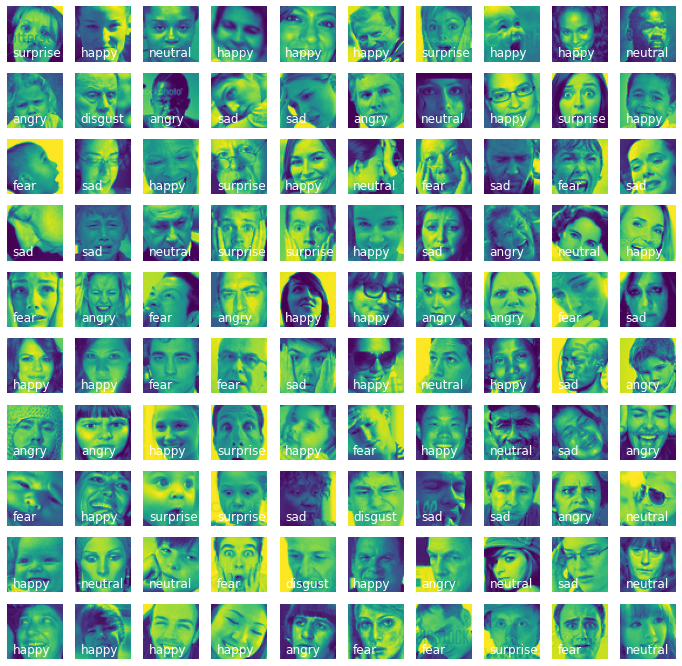

In [56]:
X, y = next(iter(train_loader))
lookup = {i: k for k, i in facial_dataset.class_to_idx.items()}
labels = torch.detach(model(X.squeeze(1)).max(-1)[1]).numpy()
length = int(len(labels)**.5)
fig, ax = plt.subplots(length, length, figsize=(12,12))
for i, axis in enumerate(ax.flatten()):
    axis.set_axis_off()
    axis.imshow(X[i][0])
    axis.text(
        s=lookup[labels[i]],
        transform=axis.transAxes,
        x=.1,y=.1, fontsize=12,
        c="w" if labels[i]==y[i] else "r")